In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from IPython import display

from scipydirect import minimize # for DIvided RECTangles (DIRECT) method
import time

In [2]:
data = pd.read_csv("compas-scores-two-years.csv")
print(data.shape)

(7214, 53)


In [3]:
labels = data['two_year_recid']
features = data.drop(columns=['two_year_recid'])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3607, 52) (3607, 52) (3607,) (3607,)


In [4]:
# X_train.to_csv('./splits/X_train_compas.csv')
# X_test.to_csv('./splits/X_test_compas.csv')
# y_train.to_csv('./splits/y_train_compas.csv')
# y_test.to_csv('./splits/y_test_compas.csv')

## 1. Load and preprocess the datasets
* In the article it was wentioned, that all categorical features were encoded using one-hot scheme, whereas all numeric attributes were normalized by dividing with their mean value.

In [4]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    To obtain dummy features from original feature `feature_to_encode`,
    add them to original dataframe `original_dataframe`,
    and drop original feature from it.
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

## 1.1 COMPAS dataset
`data_compas` - [COMPAS dataset](https://github.com/propublica/compas-analysis) (compas-scores-two-years.csv) originally comprises 7214 samples with 52 features and a binary label `two_year_recid` with two possible values `0` and `1`. In the article it was mentioned that they used the dataset containing 6150 samples with 5 features (age category, gender, race, priors count and charge degree). The sensitive attribute here is `race`, and to make it binary they selected only Black and White individuals (and that's how 6150 samples were obtained).

Let's make the following preprocessing steps:
1. Select only five features `age_cat`, `gender`, `race`, `priors_count` and `c_charge_degree` and tagret label `two_year_recid`.
2. Drop all samples with `'race' =! 'African-American'` and `'race' =! 'Caucasian'`. Then replace values of feature `race` by the rule `African-American` -> `1`, `Caucasian` -> `0`.


After preprocessing we will perform five 50:50 random splits to obtain training and test data, as it was described in the article. Each split corrresponds to one experiment.

In [5]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_test = pd.concat([train, test])

In [6]:
data_compas = train_test #pd.read_csv("compas-scores-two-years.csv") 

# Select only five features and the tagret label
data_compas = data_compas[['age_cat', 'sex', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]

# Drop all samples with 'race' =! 'African-American' and 'race' =! 'Caucasian' and 
data_compas = data_compas[(data_compas['race'] == 'African-American') | (data_compas['race'] == 'Caucasian')] 

# Replace values in 'race'
data_compas.loc[data_compas['race'] == 'African-American', 'race'] = 1
data_compas.loc[data_compas['race'] == 'Caucasian', 'race'] = 0

# Normalize all numerical features by dividing with mean value
num_features_compas = ['priors_count']
for feature in num_features_compas:
    mean = data_compas[feature].mean()
    data_compas[feature] = data_compas[feature] / mean

# Make dummy features for all categorical features
cat_features_compas = ['age_cat', 'sex', 'c_charge_degree']
for feature in cat_features_compas:
    data_compas = encode_and_bind(data_compas, feature)    

# 2. Adaptive Sensitive Reweightening (ASR) + CULEP model

## 2.1 Adaptive Sensitive Reweightening (`ReweightedClassifier`) 

In [7]:
class ReweightedClassifier:
    def __init__(self, baze_clf, alpha, beta, params = {}):
        """
        Input: 
        baze_clf   - object from sklearn with methods .fit(sample_weight=), .predict(), .predict_proba()
        alpha      - list of alphas for sensitive and non-sensitive objects [alpha, alpha']
        beta       - list of betss for sensitive and non-sensitive objects [beta, beta']
        params     - **kwargs compatible with baze_clf
        
        """
        self.baze_clf = baze_clf 
        self.model = None
        self.alpha = np.array(alpha)
        self.alphas = None
        self.beta = np.array(beta)
        self.betas = None
        self.weights = None
        self.prev_weights = None
        self.params = params
    
    def reweight_dataset(self, length, error, minority_idx):
        """
        This function recalculates values of weights and saves their previous values
        """
        if self.alphas is None or self.betas is None:
            # If alpha_0, alpha_1 or beta_0, beta_1 are not defined,
            # then define alpha_0 and beta_0 to every object from non-sensitive class,
            # and alpha_1 and beta_1 to every object from sensitive class (minority).
            self.alphas = np.ones(length) * self.alpha[0]
            self.betas = np.ones(length) * self.beta[0]
            self.alphas[minority_idx] = self.alpha[1]
            self.betas[minority_idx] = self.beta[1]
        
        # w_i_prev <- w_i for all i in dataset
        self.prev_weights = self.weights.copy()
        
        # w_i = alpha_i * L_{beta_i} (P'(y_pred_i =! y_true_i)) 
        #       + (1 - alpha_i) * L_{beta_i} (-P'(y_pred_i =! y_true_i)),
        # where 
        # L_{beta_i} (x) = exp(beta_i * x)
        self.weights = self.alphas * np.exp(self.betas * error) \
                       + (1 - self.alphas) * np.exp(- self.betas * error)
    
    
    def Dfpr_Dfnr(self, y_true, prediction, minority_idx):
        """
        This function calculates 3 values:
        1) |D_FPR| + |D_FNR|
        
        2) D_FPR = P(y_pred_i =! y_true_i | y_true_i = 1, i in S) 
                   - P(y_pred_i =! y_true_i | y_true_i = 1, i not in S) 
        
        3) D_FNR = P(y_pred_i =! y_true_i | y_true_i = 0, i in S) 
                   - P(y_pred_i =! y_true_i | y_true_i = 0, i not in S) 
        
        S - the group of sensitive objects
        ---------
        Input:
        y_true - true labels ({0,1}) of a sample for which pRule is calculated
        prediction - labels ({0,1}) of a sample for which pRule is calculated
        minority_idx - indexes of objects from a sensitive group
        """
        # majority indexes = set of all indexes / set of minority indexes,
        # where set of all indexes = all numbers from 0 to size of sample (=len(prediction))
        majority_idx = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx)
    
        # majority - array of predicted labels ({0,1}) for non-sensitive objects (majority)
        # true_majotity - array of true labels  ({0,1}) for non-sensitive objects (majority)
        majority = prediction[list(majority_idx)]
        true_majority = y_true[list(majority_idx)] 
        
        # minority - array of predicted labels ({0,1}) for sensitive objects (minority)
        # true_minority - array of true labels  ({0,1}) for sensitive objects (minority)
        minority = prediction[minority_idx]
        true_minority = y_true[minority_idx]
        
        # We estimate P(event) as frequency of the event in the sample 
        D_fpr = (true_minority != minority)[true_minority == 1].mean() \
                - (true_majority != majority)[true_majority == 1].mean()
        D_fnr = (true_minority != minority)[true_minority == 0].mean() \
                - (true_majority != majority)[true_majority == 0].mean()
        
        return D_fpr, D_fnr

        
    
    def fit(self, X_train, y_train, X_test, y_test, minority_idx, verbose=True, max_iter=30):
        # Initialize equal weights w_i = 1
        self.weights = np.ones(len(y_train))
        self.prev_weights = np.zeros(len(y_train))
        
        # Lists for saving metrics
        accuracys = []
        D_fprs = []
        D_fnrs = []
        differences = []
        accuracy_dfpr_dfnr = []
        
        # Adaptive Sensitive Reweighting
        iteration = 0
        
        while ((self.prev_weights - self.weights) ** 2).mean() > 10**(-6) and iteration < max_iter:
            
            iteration += 1
            # Train classifier on X_train with weights (w_i / sum(w_i))
            self.model = self.baze_clf(**self.params)
            self.model.fit(X_train, y_train,
                           sample_weight = self.weights / (self.weights.sum()))
            
            # Use classifier to obtain P`(y_pred_i =! y_pred) (here it is called 'error')
            prediction_proba = self.model.predict_proba(X_train)[:, 1]
            error = prediction_proba - y_train
            
            # Update weights
            self.reweight_dataset(len(y_train), error, minority_idx)
            
            # Get metrics on X_train
            prediction = self.model.predict(X_train)
            
            accuracys.append(accuracy_score(prediction, y_train))
            D_fpr, D_fnr = self.Dfpr_Dfnr(y_train, prediction, minority_idx)
            D_fprs.append(D_fpr)
            D_fnrs.append(D_fnr)
            accuracy_dfpr_dfnr.append(2*accuracys[-1] - abs(D_fpr) - abs(D_fnr))
            differences.append(((self.prev_weights - self.weights)**2).mean()**0.5)
            
            # Visualize metrics if it's needed
            if verbose:
                display.clear_output(True)
                fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 7))

                metrics = [accuracys, D_fprs, D_fnrs, accuracy_dfpr_dfnr,  differences]
                metrics_names = ["Accuracy score", "D_fpr", "D_fnr", 
                                 "2acc - |D_fpr| - |D_fnr|", "Mean of weight edits"]
                for name, metric, ax in zip(metrics_names, metrics, axes.flat):
                    ax.plot(metric, label='train')
                    ax.set_title(f'{name}, iteration {iteration}')
                    ax.legend()
                    if name == "Mean of weight edits":
                        ax.set_yscale('log')
                plt.show()
                
        return accuracys, D_fprs, D_fnrs, accuracy_dfpr_dfnr, differences
        
        
    def predict(self, X):
        return self.model.predict(X)
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def get_metrics_test(self, X_test, y_test, minority_idx_test):
        """
        Obtain pRule and accuracy for trained model
        """
        # Obtain predictions on X_test to calculate metrics
        prediction_test = self.model.predict(X_test)

        # Get metrics on test
        accuracy_test = accuracy_score(prediction_test, y_test)
        D_fpr_test, D_fnr_test = self.Dfpr_Dfnr(y_test, prediction_test, minority_idx_test)

        return accuracy_test, D_fpr_test, D_fnr_test 

## 2.2. Optimizing CULEP parameter (`train_model`)

In the article CULEP parameters are $\alpha, \alpha', \beta, \beta'$. They searched for the optimal hyperparameters in the space $\left( \alpha, \alpha', \beta, \beta' \right) \in \left[ 0, 1 \right] ^2 \times \left[ 0, 3 \right] ^2$ and used for it DIvided RECTangles (DIRECT) method. 

Each combination of parameters is evaluated with a full run of Adaptive Sensitive Reweightening algorithm on the training set. After optimization of the objective function (in case of COMPAS dataset it is `2*acc - |DFPR| - |DFNR|`), we get optimal hyperparameters $\alpha, \alpha', \beta, \beta'$. Then trained model (on the training set) with these hyperparameters make predictions on test set and the obtained metrics (accuracy, DFPR, DFNR) are reported.

The optimization of objective function is highly time-consuming. For COMPAS dataset one experiment can take around **30 minutes**. The whole process will be repeated for 5 different random splits on train and test sets. 

To be able to keep track of the process each split will be started in its own cell (instead of a loop). Each split will correspont to one experiment.

In [8]:
def prep_train_model(X_train, y_train, X_test, y_test, minority_idx):
    
    def train_model(a):
        """
        Function of 4 variables (a[0], a[1], a[2], a[3]) that will be minimized by DIRECT method.
        a[0], a[1] = alpha, alpha'
        a[2], a[3] = beta, beta'
        """
        model = ReweightedClassifier(LogisticRegression, [a[0], a[1]], [a[2], a[3]], params = {"max_iter": 4000, 'solver':'liblinear'})
        _, _, _, accuracy_dfpr_dfnr, _ = model.fit(X_train, y_train, X_test, y_test, minority_idx)

        # We'll maximize [2acc - |Dfnr| - |Dfpr|] which we get at the last iteration of Adaptive Sensitive Reweighting
        return - accuracy_dfpr_dfnr[-1]
    
    return train_model # return function for optimization

# 3. Experiments

In order to make all experiments independent from each other, all necessary variables will have name endings either `_1`, `_2`, `_3`, `_4` or `_5`.

## 3.1. Experiment 1

1) Obtain a split for the experiment.

In [10]:
train_after_join = data_compas.values[:X_train.shape[0]] # X_train + y_train
test_after_join = data_compas.values[X_train.shape[0]:] # X_test + y_test

pd_train_after_join = pd.DataFrame(train_after_join, columns=data_compas.columns) # X_train + y_train
pd_test_after_join = pd.DataFrame(test_after_join, columns=data_compas.columns) # X_test + y_test

y_train_1 = pd_train_after_join['two_year_recid']
X_train_1 = pd_train_after_join.drop(columns=['two_year_recid'])

y_test_1 = pd_test_after_join['two_year_recid']
X_test_1 = pd_test_after_join.drop(columns=['two_year_recid'])


X_train_1.to_csv('./splits/X_train_preprocessed_compas.csv')
X_test_1.to_csv('./splits/X_test_preprocessed_compas.csv')
y_train_1.to_csv('./splits/y_train_preprocessed_compas.csv')
y_test_1.to_csv('./splits/y_test_preprocessed_compas.csv')


y_train_1 = y_train_1.astype(int).values
y_test_1 = y_test_1.astype(int).values

# Obtain indexes of sensitive class
minority_idx_1 = X_train_1.reset_index(drop=True).index.values[X_train_1["race"] == 1]
minority_idx_test_1 = X_test_1.reset_index(drop=True).index.values[X_test_1["race"] == 1]

2) Perform ASR+CULEP.

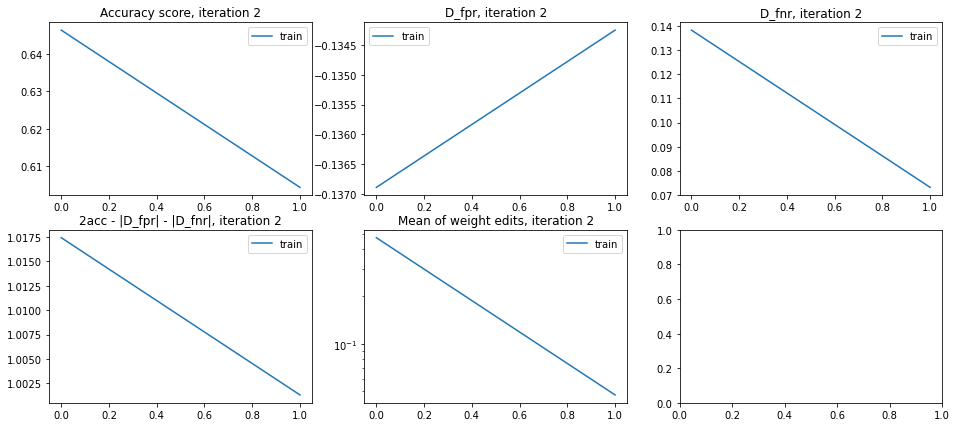

In [ ]:
objective_1 = prep_train_model(X_train_1, y_train_1, X_test_1, y_test_1, minority_idx_1)

start = time.time()
my_res_1 = minimize(objective_1, bounds=[[0.0, 1.0], [0.0, 1.0], [0.0, 3.0], [0.0, 3.0]], maxT=80, maxf=320)
stop = time.time()

print(f"Elapsed time: {stop - start} s")
print(f"Elapsed time: {(stop - start) // 60} min {(stop - start) % 60} s")
print(my_res_1)

3) Get necessary metrics on test set (for COMPAS dataset the metrics are accuracy, DFPR, DFNR).

In [14]:
# Create model with obtained hyperparameters alpha, alpha', beta, beta'
a_1 = [0.16666667, 0.53703704, 0.5,       2.83333333]#my_res_1.x
model_1 = ReweightedClassifier(LogisticRegression, [a_1[0], a_1[1]], [a_1[2], a_1[3]], params = {'solver':'liblinear'})

# Train model on X_train 
model_1.fit(X_train_1, y_train_1, X_test_1, y_test_1, minority_idx_1, verbose=False)

# Calculate metrics (pRule, accuracy) on X_test
accuracy_test_1, D_fpr_test_1, D_fnr_test_1 = model_1.get_metrics_test(X_test_1, y_test_1, minority_idx_test_1)

print('ASR+CULEP for X_test')
print(f"DFPR = {D_fpr_test_1:.6}, DFNR = {D_fnr_test_1:.6}, accuracy = {accuracy_test_1:.6}")
print(f"2acc  - |Dfnr| - |Dfpr| = {(2*accuracy_test_1 - abs(D_fpr_test_1) - abs(D_fnr_test_1)):.6}")

ASR+CULEP for X_test
DFPR = -0.0352624, DFNR = 0.00700735, accuracy = 0.646874
2acc  - |Dfnr| - |Dfpr| = 1.25148


In [16]:
y_pred_test = model_1.predict(X_test_1)
accuracy_score(y_pred_test, y_test_1)

0.6468737711364531

In [17]:
pd.DataFrame(y_pred_test).to_csv('./predictions/y_pred_test_compas.csv')

4) For the same split train simple Logistic Regression (without ASR+CULEP) on the train set. Then obtain necessary metrics on the test set.

In [15]:
# Fit LogisticRegression on X_train
model_simple = LogisticRegression(max_iter=4000, solver='liblinear')
model_simple.fit(X_train_1, y_train_1)

# Get predictions for X_test
prediction = model_simple.predict(X_test_1)

# Obtain indexes for sensitive and non-sensitive groups
majority_idx_test_1 = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx_test_1)       
minority = prediction[minority_idx_test_1]
majority = prediction[list(majority_idx_test_1)]

true_minority = y_test_1[minority_idx_test_1]
true_majority = y_test_1[list(majority_idx_test_1)] 

# Calculate metrics on X_test
accuracy_simple = accuracy_score(prediction, y_test_1)
D_fpr_simple = (true_minority != minority)[true_minority == 1].mean() \
             - (true_majority != majority)[true_majority == 1].mean()
D_fnr_simple = (true_minority != minority)[true_minority == 0].mean() \
             - (true_majority != majority)[true_majority == 0].mean()


print('Without ASR+CULEP for X_test')
print(f"DFPR = {D_fpr_simple:.6}, DFNR = {D_fnr_simple:.6}, accuracy = {accuracy_simple:.6}")
print(f"2acc  - |Dfnr| - |Dfpr| = {(2*accuracy_simple - abs(D_fpr_simple) - abs(D_fnr_simple)):.6}")

Without ASR+CULEP for X_test
DFPR = -0.30304, DFNR = 0.215262, accuracy = 0.667322
2acc  - |Dfnr| - |Dfpr| = 0.816343
